## Trailing losses ##

Trailing losses occur for moving objects when their motion during an exposure (or visit) makes them cover an area larger than the PSF. This notebook investigates the SNR losses due to trailing, as expected for LSST (with its 2-snap per visit observations) and the effect of DM source detection on the limiting magnitude expected for a visit. 
There are also some visualizations of what moving objects might look like in LSST visits (including the dip or gap that may occur in the trail due to 2 snaps per visit observations), and an estimate of what fraction of NEOs or PHAs may be affected by these trailing losses.

Note that for LSST, each visit is composed of 2 shorter exposures. The pair is used to reject cosmic rays, but will be simply added together for a single visit limiting magnitude equivalent to the combination of the two visits (LSST is sky-noise limited in all bands except u band, which also has a non-negligble read-noise contribution). The spacing between the two exposures is nominally 2 seconds (the readout time), however the shutter requires 1 second to move across the field of view. The shutter is composed of two blades which travel across the fov one after another (e.g. one blade 'opens' the camera, the second blade 'closes' it; for the next exposure, the second blade 'opens', followed by the first blade 'closing' the camera and returning to the starting positions). Thus, the midpoint of any particular exposure varies by 1 second across the fov but the total exposure time is constant. The 'gap' between a pair of exposures in a visit varies from 2 seconds to 4 seconds, depending on location in the fov relative to the shutter movement. 

If the shutter is opening L-R then R-L, then a point on the L side of the camera will have an exposure midpoint 1 second earlier than a point on the R side of the camera, will have a 4 second gap between exposures instead of a 2 second gap, and have the midpoint of the second exposure 1 second later than the R side of the camera. This may complicate trailing calculations. 

Each object will have the same trail length in the individual exposures, and the same overall 'central' location, but slightly different combined trail length due to variation in length of gap in middle of the visit. 

---
Simple example of motion (just to show gap between exposures in a single visit).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

0.354166666667 0.354166666667


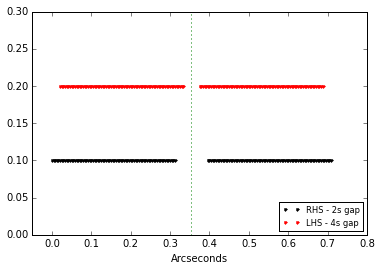

In [2]:
velocity = 0.5 #deg/day
velocity = velocity /24.0 #arcseconds/second
exposuretime = np.arange(0, 15.01, 0.2) #seconds
timesL = np.concatenate([exposuretime, exposuretime+exposuretime.max()+4])
timesR = np.concatenate([exposuretime+1., exposuretime+exposuretime.max()+2.+1])
#print timesL.mean(), timesL.min(), timesL.max()
#print timesR.mean(), timesR.min(), timesR.max()
positionL = velocity * timesL
positionR = velocity * timesR
plt.figure()
plt.plot(positionL, np.zeros(len(positionL))+0.1, 'k.', label='RHS - 2s gap')
plt.plot(positionR, np.zeros(len(positionR))+0.2, 'r.', label='LHS - 4s gap')
plt.ylim(0, 0.3)
plt.xlim(-0.05, None)
plt.xlabel('Arcseconds')
plt.legend(loc='lower right', fontsize='smaller')
plt.axvline(positionL.mean(), color='g', linestyle=':')
print positionL.mean(), positionR.mean()

---
#PSF#

Now let's add in the seeing distribution, to look at the flux profile of the sources. 

Assume the PSF (for a stationary source) is consistent with Kolmogorov turbulence (see section 4.4 of the [SNR doc](http://ls.st/lse-40)). For moving objects, we can create many 'stationary' PSFs, at a series of locations along the trail of the object.

A good description of the PSF is a double-gaussian: (eqn 30 SNR doc) 
\begin{equation}
p_K(r | \alpha) \, =  \, 0.909 \left( p(r | \alpha) + 0.1 p(r | 2\alpha) \right) \\
p(r | \alpha) \, = \frac{1}{2 \pi \alpha^2} exp( \frac{-r^2}{2 \alpha^2})
\end{equation}

This influences $n_{eff}$ when calculating the number of pixels for SNR as well (sum here is over pixels). (eqn 26 SNR doc)
\begin{equation}
n_{eff} = \sum_i w_i = \frac{1}{\sum_i p_i^2} \\
n_{eff} = 2.436 \, (FWHM / pixelscale)^2
\end{equation}

In [3]:
def stationaryPSF(seeing, totalflux=1, xcen=0, ycen=0, stepsize=0.01, alpharad=10.0):
    "Distribute flux across PSF. seeing in arcseconds"
    # Translate 'seeing' FWHM to gaussian 'sigma' (alpha in the equations above)
    alpha = seeing / 2.355
    maxrad = alpha*alpharad
    x = np.arange(0, 2*maxrad, stepsize) 
    x = x - x.mean() + xcen
    y = np.arange(0, 2*maxrad, stepsize)
    y = y - y.mean() + ycen
    xi, yi = np.meshgrid(x, y)
    radius = np.sqrt((xi-xcen)**2 + (yi-ycen)**2)
    p1 = 1.0/(2.0*np.pi*alpha**2) * np.exp(-radius**2/(2.0*alpha**2))
    p2 = 1.0/(2.0*np.pi*(2*alpha)**2) * np.exp(-radius**2/(2.0*(2*alpha)**2))
    p = 0.909*(p1 + 0.1*p2)
    flux = p * totalflux
    # Flux = flux[y][x], although here it doesn't matter because len(x) = len(y)
    return x, y, flux

In [4]:
from scipy import integrate 

def sumPSF(x, y, flux):
    dx = np.max(np.diff(x))
    dy = np.max(np.diff(y))
    sumVal = integrate.simps(integrate.simps(flux, dx=dx), dx=dy)
    return sumVal 

In [5]:
from scipy import interpolate 

def zoomImage(x, y, flux, zoom=[-1, 1, -1, 1], zmax=None, nbins=200.0, pixelize=False, pixelscale=0.2):
    """Zoom in and show the image in region 'zoom'.
    'pixelize' translates x/y into pixels and displays the image as would-be-seen with pixels."""
    if zmax is None:
        zmax = flux.max()
    if pixelize:
        x_pix = x / pixelscale
        y_pix = y / pixelscale
        xg = np.arange(zoom[0], zoom[1]+0.5, 1)
        yg = np.arange(zoom[2], zoom[3]+0.5, 1)
        xgrid, ygrid = np.meshgrid(xg, yg)
        showflux = interpolate.interpn((y_pix, x_pix), flux, (ygrid, xgrid),
                                      method='splinef2d', bounds_error=False, fill_value=0)
        plt.imshow(showflux, extent=zoom, vmin=0, vmax=zmax, origin='lower', interpolation='none')
        plt.colorbar()
        plt.xlabel('Pixels')
        plt.ylabel('Pixels')
    else:
        nbins = float(nbins)
        binsize = (zoom[1]-zoom[0])/nbins
        xg = np.arange(zoom[0], zoom[1]+binsize, binsize)
        binsize = (zoom[3] - zoom[2])/nbins
        yg = np.arange(zoom[2], zoom[3]+binsize, binsize)
        xgrid, ygrid = np.meshgrid(xg, yg)
        showflux = interpolate.interpn((y, x), flux, (ygrid, xgrid), 
                                       method='splinef2d', bounds_error=False, fill_value=0)
        plt.imshow(showflux, extent=zoom, vmin=0, vmax=zmax, origin='lower')
        plt.colorbar()
        plt.xlabel('Arcseconds')
        plt.ylabel('Arcseconds')

In [6]:
def crossSection(x, y, flux, xi=None, yi=None):
    """Take a cross-section at xi/yi and return the flux values."""
    if xi is None:
        xi = np.mean(x)
    if yi is None:
        yi = np.mean(y)
    # Find closest point in x/y arrays.
    xindx = np.argmin(np.abs(x-xi))
    yindx = np.argmin(np.abs(y-yi))
    fluxx = flux[yindx][:]
    fluxy = np.swapaxes(flux, 0, 1)[xindx][:]
    return fluxx, fluxy

Check these tools out with stationary PSF.

0.99989989357
0.99989989357
0.999899894954


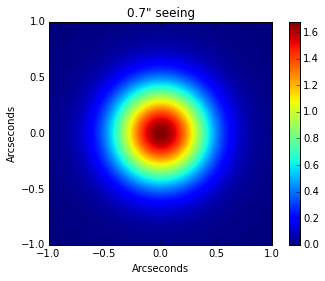

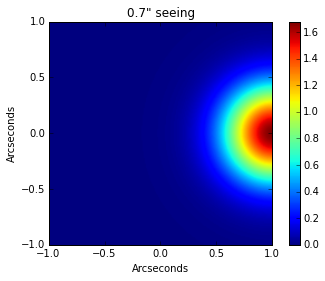

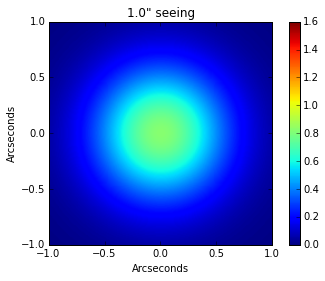

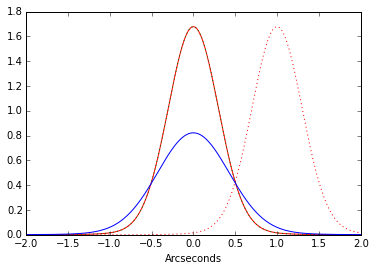

In [7]:
x, y, flux = stationaryPSF(0.7, totalflux=1)
print sumPSF(x, y, flux)
plt.figure()
zoomImage(x, y, flux)
plt.title('0.7" seeing')
plt.figure()
fluxx, fluxy = crossSection(x, y, flux)
x1 = x
fx1 = fluxx

x, y, flux = stationaryPSF(0.7, xcen=1)
print sumPSF(x, y, flux)
plt.figure()
zoomImage(x, y, flux)
plt.title('0.7" seeing')
plt.figure()
fluxx, fluxy = crossSection(x, y, flux, xi=1)
x2 = x
fx2 = fluxx
y2 = y
fy2 = fluxy

x, y, flux = stationaryPSF(1.0, totalflux=1)
print sumPSF(x, y, flux)
plt.figure()
zoomImage(x, y, flux, zmax=1.6)
plt.title('1.0" seeing')
plt.figure()
fluxx, fluxy = crossSection(x, y, flux)
plt.plot(x1, fx1, 'r')
plt.plot(x2, fx2, 'r:')
plt.plot(y2, fy2, 'g:')
plt.plot(x, fluxx, 'b')
plt.xlim(-2, 2)
plt.xlabel('Arcseconds')

#Moving object PSF#

Now simulate a moving object as a series of stationary PSFs, summing all the flux vlaues contributed by each stationary PSF.

In [8]:
def movingPSF(velocity=1.0, seeing=0.7, totalflux=1., side='L'):
    "Simulate a moving object;  velocity (deg/day), seeing(arcsecond), side='L' or 'R' (L=4sec gap)"""
    velocity = velocity / 24.0 #arcsecond/second
    exposureTimeSteps = seeing/velocity/20.0
    exposuretime = np.arange(0, 15+exposureTimeSteps/2.0, exposureTimeSteps) #seconds
    timesL = np.concatenate([exposuretime, exposuretime+exposuretime.max()+4])
    timesR = np.concatenate([exposuretime+1., exposuretime+exposuretime.max()+2.+1])
    positionL = velocity * timesL
    positionR = velocity * timesR
    xlist = []
    ylist = []
    fluxlist = []
    if side=='L':
        positions = positionL
    else:
        positions = positionR
    for p in (positions):
        xcen = p
        x, y, flux = stationaryPSF(0.7, xcen=xcen, ycen=0)
        xlist.append(x)
        ylist.append(y)
        fluxlist.append(flux)

    xmin = np.array([x.min() for x in xlist]).min()
    xmax = np.array([x.max() for x in xlist]).max()
    ymin = np.array([y.min() for y in ylist]).min()
    ymax = np.array([y.max() for y in ylist]).max()
    stepsize = 0.01 #arcseconds
    x = np.arange(xmin, xmax+stepsize, stepsize)
    y = np.arange(ymin, ymax+stepsize, stepsize)
    xgrid, ygrid = np.meshgrid(x, y)
    flux = np.zeros(np.shape(xgrid), float)
    for xi, yi, fi in zip(xlist, ylist, fluxlist):
        f = interpolate.interpn((yi, xi), fi, (ygrid, xgrid), bounds_error=False, fill_value=0)
        flux += f
    fluxSum = sumPSF(x, y, flux)
    flux = flux / fluxSum * totalflux
    return x, y, flux

In [9]:
velocity = 1.0 #deg/day
seeing = 0.7 #arcseconds
x, y, flux = movingPSF(velocity=velocity, seeing=seeing)

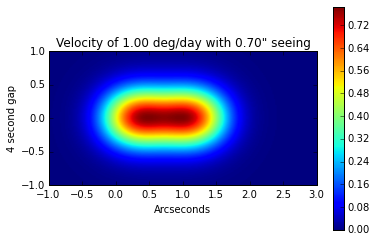

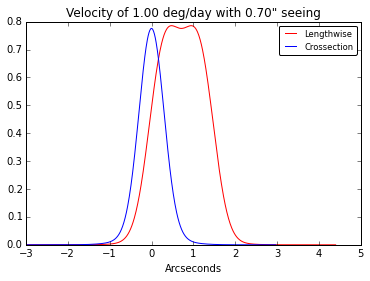

In [10]:
zoomImage(x, y, flux, zoom=[-1, 3, -1, 1])
plt.title('Velocity of %.2f deg/day with %.2f" seeing' %(velocity, seeing))
plt.ylabel('4 second gap')
plt.figure()
fluxx, fluxy = crossSection(x, y, flux)
plt.figure()
plt.plot(x, fluxx, 'r', label='Lengthwise')
plt.plot(y, fluxy, 'b', label='Crossection')
plt.legend(loc='upper right', fontsize='smaller', fancybox=True)
plt.xlabel('Arcseconds')
plt.title('Velocity of %.2f deg/day with %.2f" seeing' %(velocity, seeing))

Above is with a smooth sub-pixel sampling. At 1 deg/day, on the 4 second gap (L) hand side of the chip, there is a dip in the smoothly sampled flux. However, it's small in width - the tracks are only separated by about 0.1", which is less than a pixel (0.2"/pixel for LSST). We can look at how the flux would appear if it was only sampled at the center of each pixel. 

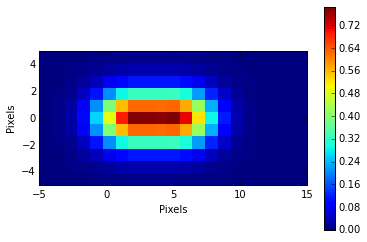

In [12]:
# try pixelizing the flux
pixelscale = 0.2
# 1 deg/day not nyquist sampled; 2 deg/day is definitely visible!
zoom=[-1, 3, -1, 1]
zoompix = [int(z/pixelscale) for z in zoom]
zoomImage(x, y, flux, zoom=zoompix, pixelize=True)

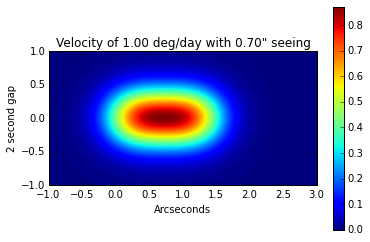

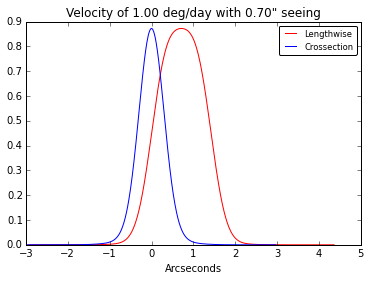

In [13]:
x, y, flux = movingPSF(side='R', velocity=velocity, seeing=seeing)
zoomImage(x, y, flux, zoom=[-1, 3, -1, 1])
plt.title('Velocity of %.2f deg/day with %.2f" seeing' %(velocity, seeing))
plt.ylabel('2 second gap')
plt.figure()
fluxx, fluxy = crossSection(x, y, flux)

plt.figure()
plt.plot(x, fluxx, 'r', label='Lengthwise')
plt.plot(y, fluxy, 'b', label='Crossection')
plt.legend(loc='upper right', fontsize='smaller', fancybox=True)
plt.xlabel('Arcseconds')
plt.title('Velocity of %.2f deg/day with %.2f" seeing' %(velocity, seeing))

1.3058850213 1.3058850213


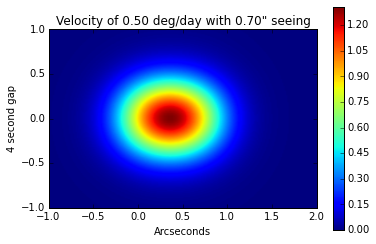

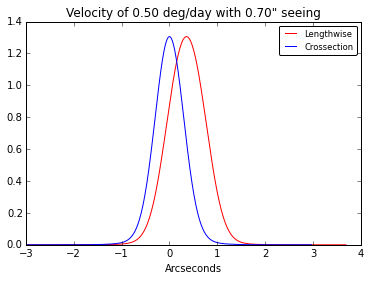

In [14]:
velocity=0.5
x, y, flux = movingPSF(side='L', velocity=velocity, seeing=seeing)
zoomImage(x, y, flux, zoom=[-1, 2, -1, 1])
plt.title('Velocity of %.2f deg/day with %.2f" seeing' %(velocity, seeing))
plt.ylabel('4 second gap')
plt.figure()
fluxx, fluxy = crossSection(x, y, flux)
print fluxx.max(), fluxy.max()

plt.figure()
plt.plot(x, fluxx, 'r', label='Lengthwise')
plt.plot(y, fluxy, 'b', label='Crossection')
plt.legend(loc='upper right', fontsize='smaller', fancybox=True)
plt.xlabel('Arcseconds')
plt.title('Velocity of %.2f deg/day with %.2f" seeing' %(velocity, seeing))

---
#SNR#

Moving on to calculating SNR, for 'optimally extracted' profiles (i.e. we recover all the flux, but have a higher sky background than a similar stationary PSF, because there's extra sky background). This primarily comes down to calculating $n_{eff}$. 

In [11]:
from scipy import integrate

def calcNeff(x, y, psfprofile, pixelscale=0.2):
    # Find dx/dy intervals for integration. They should be uniform based on methods here.
    dx = np.max(np.diff(x))
    dy = np.max(np.diff(y))
    # Make sure psfprofile normalizes to 1.
    psfSum = integrate.simps(integrate.simps(psfprofile, dx=dx), dx=dy)
    psfprofile /= psfSum
    # Calculate neff (area).
    neff = 1.0 / integrate.simps(integrate.simps(psfprofile**2, dx=dx), dx=dy)
    # Convert to pixels.
    neff = neff / pixelscale**2
    return neff

In [12]:
# Calculate Neff for stationary sources.
pixelscale = 0.2 #arcseconds/pixel
seeing = 0.7 #arcseconds
neff1 = 2.436 * (seeing/pixelscale)**2
print 'Standard Neff', neff1
# Calculate Neff from sum(1/p) for each pixel.
x, y, flux = stationaryPSF(seeing=seeing, totalflux=1.0, alpharad=20.0, stepsize=0.01)
neff = calcNeff(x, y, flux)
print 'Calculated neff from PSF',  neff
print '% difference:', (neff-neff1)/neff1*100.0

Standard Neff 29.841
Calculated neff from PSF 31.0257004484
% difference: 3.97004272103


In [13]:
# Calculate Neff for moving sources.
velocity = 0.5
seeing = 0.7
x, y, flux = movingPSF(side='L', velocity=velocity, seeing=seeing, totalflux=1.0)
neff = calcNeff(x, y, flux)
print 'Calculated neff from PSF (LHS), velocity %.2f seeing %.1f: %f' %(velocity, seeing, neff)
x, y, flux = movingPSF(side='R', velocity=velocity, seeing=seeing, totalflux=1.0)
neff = calcNeff(x, y, flux)
print 'Calculated neff from PSF (RHS), velocity %.2f seeing %.1f: %f' %(velocity, seeing, neff)

Calculated neff from PSF (LHS), velocity 0.50 seeing 0.7: 38.859467
Calculated neff from PSF (RHS), velocity 0.50 seeing 0.7: 37.664407


In [36]:
velocities = np.arange(0.1, 5.0, 0.2)
seeing = 0.7
neff_vel = np.zeros(len(velocities), float)
for i, v in enumerate(velocities):
    x, y, flux = movingPSF(side='L', velocity=v, seeing=seeing, totalflux=1.0)
    neff_vel[i] = calcNeff(x, y, flux)

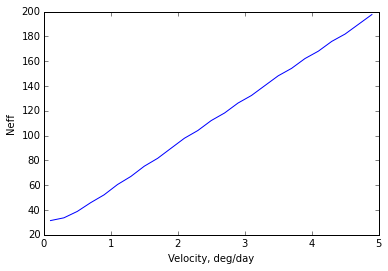

In [37]:
plt.plot(velocities, neff_vel)
plt.xlabel('Velocity, deg/day')
plt.ylabel('Neff')

We can calculate SNR (eqn 41 in SNR doc) (assuming gain=1):
\begin{equation}
SNR = \frac {C_b} {(C_b + n_{eff} (B_b + \sigma_I^2))^{1/2}}
\end{equation}
And equation 45-46 of the SNR doc invert this to:
\begin{equation}
C_b(SNR) = \frac{SNR^2}{2} + \left( \frac{SNR^4}{4}+ SNR^2 V_n \right) ^{1/2} \\
V_n = n_{eff} (B_b + \sigma_I^2) \\
\end{equation}

In [38]:
# Calculate totalflux equivalent to (optimally extracted) SNR=5.0 for this range of velocities.
SNR = 5.0
sky = 2000.
inst_noise = 10.0
Vn = neff_vel*(sky + inst_noise)
counts =  SNR**2/2. + np.sqrt(SNR**4/4. + SNR**2 * Vn)
mags = 2.5*np.log10(counts)
# and for a stationary source.
x, y, flux = stationaryPSF(seeing=seeing, totalflux=1.)
neff_stat = calcNeff(x, y, flux)
Vn = neff_stat*(sky + inst_noise)
counts = SNR**2/2. + np.sqrt(SNR**4/4. + SNR**2 * Vn)
mag_stat = 2.5*np.log10(counts) # Not zeropointed!
# Subtract the two to find the magnitude increase required to stay at SNR=5.0 (optimal extraction) as objects trail.
mags = mags - mag_stat

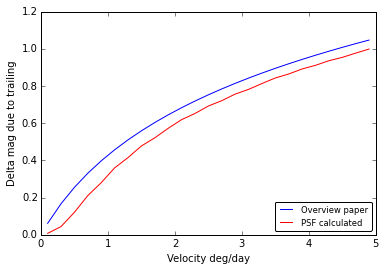

In [39]:
# Overview paper trailing losses.
dmT = 1.25*np.log10(1 + 0.028 * velocities * 30.0 / seeing)
plt.plot(velocities, dmT, 'b', label='Overview paper')
# Calculated trailing losses.
plt.plot(velocities, mags, 'r', label='PSF calculated')
plt.legend(loc='lower right', fancybox=True, fontsize='smaller')
plt.xlabel('Velocity deg/day')
plt.ylabel('Delta mag due to trailing')

This result matches closely with the trailing loss formula used in the LSST Overview paper, so it looks about right. This is the inevitable loss in SNR due to the fact that the moving object trails across more sky pixels, thus adding more sky noise into the measurement of its (optimally extracted) source. 

---
We also need to look at the effect that results from DM's source detection algorithms. DM will only detect sources which are brighter than some threshhold (currently 5$\sigma$) in a PSF-convolved image. Because our sources are moving, their peak fluxes (convolved with the stationary PSF) will be lower than a similar stationary source.

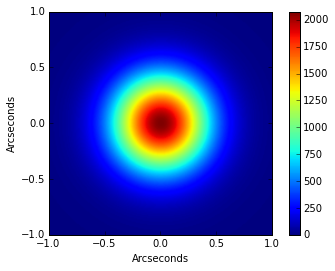

In [14]:
# Find counts at threshhold for stationary source. 
SNR = 5.0
sky = 2000.
inst_noise = 10.0
neff_stat = 2.436 * (seeing/pixelscale)**2
Vn = neff_stat*(sky + inst_noise)
counts = SNR**2/2. + np.sqrt(SNR**4/4. + SNR**2 * Vn)
x_stat, y_stat, flux_stat = stationaryPSF(seeing=seeing, totalflux=counts) 
zoomImage(x_stat, y_stat, flux_stat)

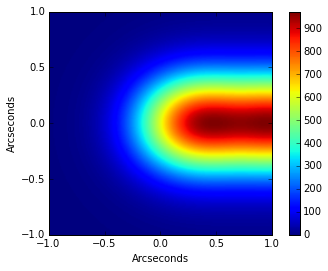

In [15]:
# Distribute similar counts in moving object.
velocity = 1.0 
x_mo, y_mo, flux_mo = movingPSF(seeing=seeing, velocity=velocity, totalflux=counts)
zoomImage(x_mo, y_mo, flux_mo)

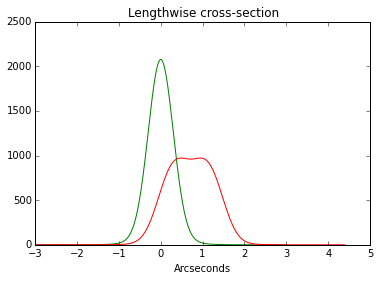

In [16]:
# Compare the peak brightness of the two (without correlation with PSF)
fx_stat, fy_stat = crossSection(x_stat, y_stat, flux_stat)
fx_mo, fy_mo = crossSection(x_mo, y_mo, flux_mo)
plt.plot(x_stat, fx_stat, 'g')
plt.plot(x_mo, fx_mo, 'r')
plt.xlabel("Arcseconds")
plt.title('Lengthwise cross-section')

In [28]:
# Generate a PSF profile that we will correlate with the stationary and moving object sources 
# (this is the LSST detection filter)
x_psf, y_psf, psfprofile = stationaryPSF(seeing=seeing, totalflux=1.0, stepsize=0.01, alpharad=10.0)

9966425.30041 2076.35443012


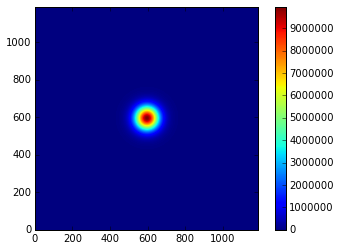

In [37]:
from scipy import signal
filtered_stat = signal.fftconvolve(flux_stat, psfprofile)
plt.imshow(filtered_stat, origin='lower')
plt.colorbar()
print filtered_stat.max(), flux_stat.max()

6407915.11066 971.68683124


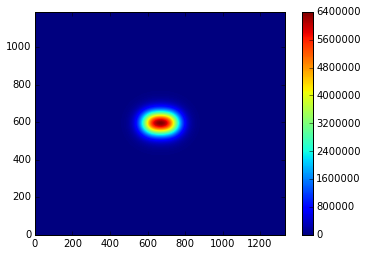

In [38]:
filtered_mo = signal.fftconvolve(flux_mo, psfprofile)
plt.imshow(filtered_mo, origin='lower')
plt.colorbar()
print filtered_mo.max(), flux_mo.max()

increasing counts in moving object by 1.55533042
equivalent to change in magnitude of 0.479556665627
9966425.30041 1511.29408734


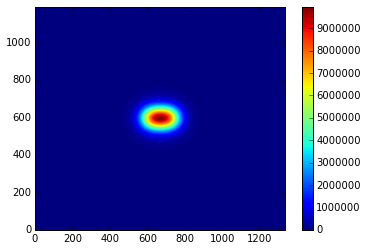

In [39]:
# So how much brighter do we have to get as a moving object in order to hit the 
#  out_stat.max() value, which is the detection threshhold?
ratio = filtered_stat.max() / filtered_mo.max()
print "increasing counts in moving object by", ratio
dmag = 2.5*np.log10(ratio)
print "equivalent to change in magnitude of", dmag
flux_mo2 = flux_mo * ratio
filtered_mo2 = signal.fftconvolve(flux_mo2, psfprofile)
plt.imshow(filtered_mo2, origin='lower')
plt.colorbar()
print filtered_mo2.max(), flux_mo2.max()

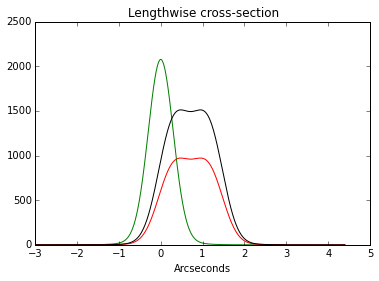

In [32]:
fx_stat, fy_stat = crossSection(x_stat, y_stat, flux_stat)
fx_mo, fy_mo = crossSection(x_mo, y_mo, flux_mo)
fx_mo2, fy_mo2 = crossSection(x_mo, y_mo, flux_mo2)
plt.plot(x_stat, fx_stat, 'g')
plt.plot(x_mo, fx_mo, 'r')
plt.plot(x_mo, fx_mo2, 'k')
plt.xlabel("Arcseconds")
plt.title('Lengthwise cross-section')

In [40]:
counts_stat = counts
mags_stat = 2.5*np.log10(counts_stat)

In [44]:
velocities = np.arange(0.1, 2.5, 0.25)
ratios = np.zeros(len(velocities), float)
moving_dmags = np.zeros(len(velocities), float)
trailing_mags = np.zeros(len(velocities), float)
for i, v in enumerate(velocities):
    x, y, flux = movingPSF(seeing=seeing, velocity=v, totalflux=counts)
    filtered_mo = signal.fftconvolve(flux, psfprofile)
    ratios[i] = filtered_stat.max() / filtered_mo.max() 
    moving_dmags[i] = 2.5*np.log10(ratios[i])
    neff = calcNeff(x, y, flux)
    Vn = neff*(sky + inst_noise)
    counts_mo =  SNR**2/2. + np.sqrt(SNR**4/4. + SNR**2 * Vn)
    trailing_mags[i] = 2.5*np.log10(counts_mo) - mags_stat

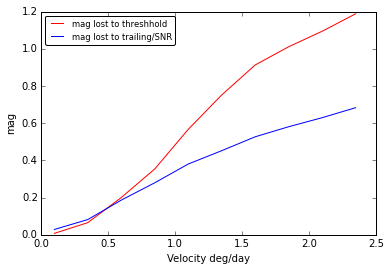

In [45]:
plt.plot(velocities, moving_dmags, 'r', label='mag lost to threshhold')
plt.plot(velocities, trailing_mags, 'b', label='mag lost to trailing/SNR')
plt.xlabel('Velocity deg/day')
plt.ylabel('mag')
plt.legend(loc='upper left', fontsize='smaller', fancybox=True)

Well, that's pretty severe. See what Mario's formula comes up with. 

---
#NEO/PHA population#
The overall effect of these trailing losses depends on what fraction of the NEO or PHA population has velocities in this range. 

In [52]:
from itertools import repeat
import pandas
import pyoorb as oo

In [55]:
orbits = pandas.read_table('pha20141031.des', sep='\s', engine='python')
orbits = orbits.to_records()

In [56]:
timestep  = 1.0 # in days
timestart = 49353.0 # start of opsim; pretty random really.
nyears = 10.0 # years
timeend = timestart + 365 * nyears + 1.0
times = np.arange(timestart, timeend + timestep/2.0, timestep)
# For pyoorb, we need to tag times with timescales;
# 1= MJD_UTC, 2=UT1, 3=TT, 4=TAI
ephTimes = np.array(zip(times, repeat(4, len(times))), dtype='double', order='F')
print ephTimes.shape

(3652, 2)


In [57]:
oo.pyoorb.oorb_init(ephemeris_fname="")

3

In [58]:
def packOorbElem(sso):
    oorbelems = [sso['!!ObjID'], sso['q'], sso['e'], np.radians(sso['i']), np.radians(sso['Omega/node']), 
             np.radians(sso['omega/argperi']), sso['t_p'],  2, sso['t_0'], 3, sso['magHv'], 0.15]
    oorbelems = np.column_stack(oorbelems)
    return oorbelems

In [60]:
def unpackEphs(oorbephem):
    # oorbephem = single ephem - i.e. for single object. 
    # then swap time/ephemeris element, so that we can get easy arrays of things like 'ra', 'dec'.
    oorbephem = np.swapaxes(oorbephem, 0, 1)
    dist = oorbephem[0]
    ra = oorbephem[1]
    dec = oorbephem[2]
    magV = oorbephem[3]
    time = oorbephem[4]'phaseangle', 'solarelon', 'velocity'])
    return ephs

In [ ]:
elon_limit = 45.0
velbins = np.concatenate([np.arange(0, 1, 0.025), np.arange(1, 5, 0.05), np.arange(5, 10, 0.1)])
orbsubset = orbits
velFracs = np.zeros((len(orbsubset), len(velbins)-1), float)
velsAtTime = np.zeros((len(orbsubset), len(ephTimes)), float) - 999

for i, sso in enumerate(orbsubset):
    oorbelems = packOorbElem(sso)
    oorbephems, err = oo.pyoorb.oorb_ephemeris(in_orbits = oorbelems, in_obscode=807, in_date_ephems=ephTimes)
    ephs = unpackEphs(oorbephems[0])
    # See how much of the time this object was trailing (when solar elongation suitable for observations)
    condition = np.where(ephs['phaseangle']> elon_limit)
    velsAtTime[i][condition] = ephs['velocity'][condition]
    velFracs[i], b = np.histogram(ephs[condition]['velocity'], bins=velbins)    

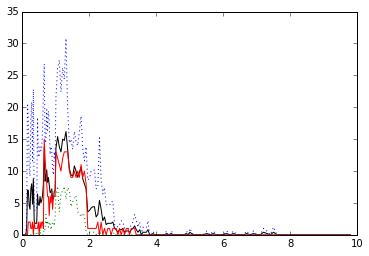

In [146]:
# For all objects, what fraction of their time is spent moving quickly?
plt.plot(b[:-1], np.mean(velFracs, axis=0), 'k')
plt.plot(b[:-1], np.median(velFracs, axis=0), 'r')
plt.plot(b[:-1], np.percentile(velFracs, 90, axis=0), 'b:')
plt.plot(b[:-1], np.percentile(velFracs, 10, axis=0), 'g:')

In [159]:
# At any particular time, what fraction of objects are moving quickly?
vTime = velsAtTime.swapaxes(0, 1)
fracFast = np.zeros(len(vTime))
for i, vT in enumerate(vTime):
    condition = np.where(vT != -999)
    nVis = len(condition[0])
    nFast = vT[condition] > 0.8
    if nVis == 0:
        fracFast[i] = 0
    else:
        fracFast[i] = len(nFast) / float(nVis)

[ 0.  0.  0. ...,  1.  1.  1.]
